In [1]:
import os.path
from collections import Counter

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
SIMULATIONS = 1000 * 1000


ec_votes = {
    "WA": 12,
    "OR": 7,
    "CA": 55,
    "NV": 6,
    "MT": 3,
    "ID": 4,
    "UT": 6,
    "AZ": 11,
    "CO": 9,
    "NM": 5,
    "WY": 3,
    "ND": 3,
    "SD": 3,
    "NE": 2, "NE1": 1, "NE2": 1, "NE3": 1,
    "KS": 6,
    "OK": 7,
    "TX": 38,
    "LA": 8,
    "AR": 6,
    "MO": 10,
    "IA": 6,
    "MN": 10,
    "WI": 10,
    "IL": 20,
    "MI": 16,
    "IN": 11,
    "TN": 11,
    "KY": 8,
    "MS": 6,
    "AL": 9,
    "GA": 16,
    "FL": 29,
    "HI": 4,
    "AK": 3,
    "DE": 3,
    "DC": 3,
    "VT": 3,
    "ME": 2, "ME1": 1, "ME2": 1,
    "NH": 4,
    "RI": 4,
    "WV": 5,
    "CT": 7,
    "SC": 9,
    "MD": 10,
    "MA": 11,
    "VA": 13,
    "NJ": 14,
    "NC": 15,
    "OH": 18,
    "PA": 20,
    "NY": 29,
}

# Pixels to the midpoint
fifty_percent = 206.

# Number of stdevs covered by symmetric 80%
eighty_percent = 1.2816

In [3]:
def prob_of_winning(fifty_percent, mean, stdev):
    zscore = (fifty_percent - mean) / stdev
    return st.norm.cdf(zscore)


def get_dists(filename):
    with open(filename) as handle:
        data = handle.read()
    print("data: {0}".format(len(data)))
    soup = BeautifulSoup(data, "lxml")

    state_class = {"class": "state"}
    forecast_class = {"class": "forecast"}
    rect_class = {"class": "ci D"}

    states = soup.find_all("g", state_class)
    print("States: {0}".format(len(states)))
    ecs = [
        ec_name["data-state"]
        for state in states
        for ec_name in state.find_all("rect", {"class": "click"})
    ]
    print("ECS: {0}".format(len(ecs)))

    forecasts = [
        forecast
        for state in states
        for forecast in state.find_all("g", forecast_class)
    ]
    print("forecasts: {0}".format(len(forecasts)))
    
    dists = [
        {
            "name": ec,
            "width": float(rect["width"]),
            "left": float(rect["x"]),
            # "center": float(circle["cx"])
        }
        for forecast, ec in zip(forecasts, ecs)
        for rect, circle in zip(forecast.find_all("rect", rect_class), forecast.find_all("circle"))
    ]
    print("Districts: {0}".format(len(dists)))

    # Back out the mean and stdev, precalculate linear probability
    for d in dists:
        mean = d["left"] + d["width"] / 2.
        stdev = d["width"] / (2 * eighty_percent)
        prob = prob_of_winning(fifty_percent, mean, stdev)
        d["prob"], d["mean"], d["stdev"] = prob, mean, stdev

    return ecs, dists

Perform draws from each state's distribution of outcomes to simulate possible election outcomes.

In [4]:
def simulate(ecs, dists):
    """
    Do draws from a linear distribution, counting state EC votes
    when the random variable does not exceed the probability of
    winning the state.
    """
    state_probs = np.array([d["prob"] for d in dists])
    prob_iter = (
        np.sum([
            ec_votes[state]
            for state, prob, state_prob in zip(ecs, np.random.random(len(dists)), state_probs)
            if state_prob > prob
        ])
        for _ in range(SIMULATIONS)
    )
    return Counter(prob_iter)


In [5]:
import requests

def get_html_data():
    filename = "2016 Election Forecast _ FiveThirtyEight.htm"
    #url = "http://projects.fivethirtyeight.com/2016-election-forecast/"
    #r = requests.get(url)
    #filename = "a.html"
    #with open(filename, "w") as handle:
    #    handle.write(r.text)
    return filename

In [6]:
print("Pulling forecast data")
filename = get_html_data()

print("Extract distribution data")
ecs, dists = get_dists(filename)

print("Simulate election")
results = simulate(ecs, dists)
print("Done")

Pulling forecast data
Extract distribution data
data: 2681119
States: 56
ECS: 56
forecasts: 56
Districts: 56
Simulate election
Done


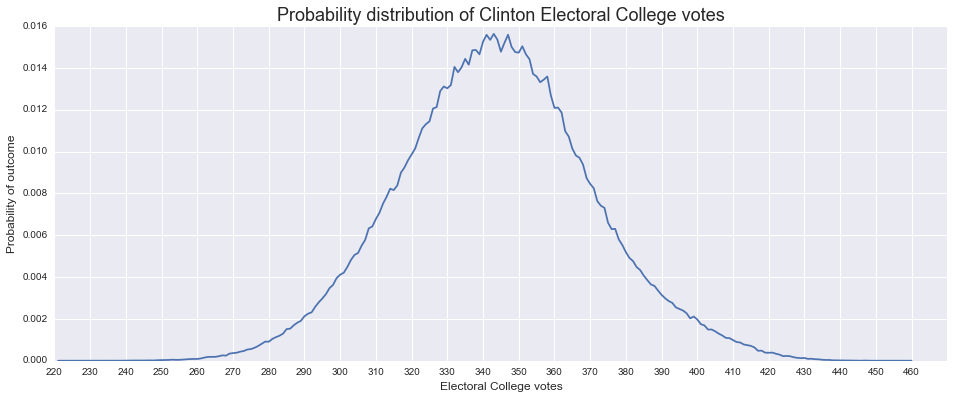

In [7]:
x = list(results.keys())
y = [v / float(SIMULATIONS) for v in results.values()]
min_x, max_x = min(x) - min(x) % 10, max(x) + (10 - max(x) % 10)
plt.figure(figsize=(16, 6))
plt.plot(x, y)
plt.xticks(range(min_x, max_x, 10))
plt.xlim([min_x, max_x])
plt.xlabel("Electoral College votes", fontsize=12)
plt.ylabel("Probability of outcome", fontsize=12)
plt.title("Probability distribution of Clinton Electoral College votes", fontsize=18)
plt.show()

In [8]:
wins = sum(v for k, v in results.items() if k >= 270)
losses = sum(v for k, v in results.items() if k <= 268)

print(float(wins) / SIMULATIONS)
print(float(losses) / SIMULATIONS)

0.997339
0.00232


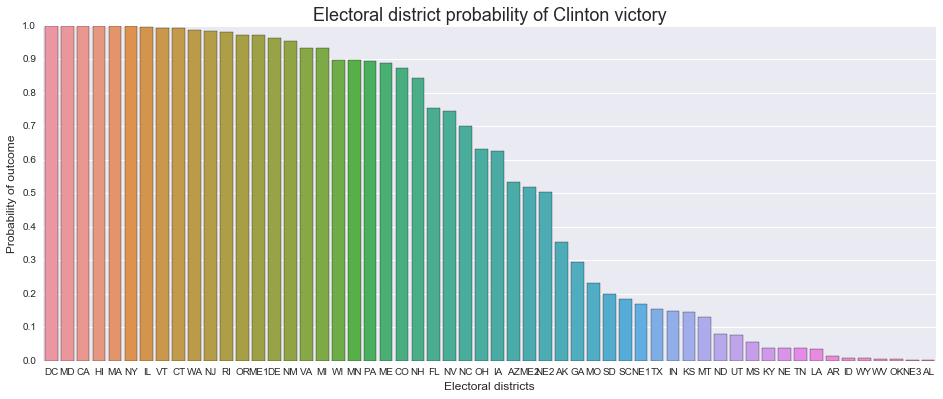

In [9]:
from operator import itemgetter

sorted_dist = sorted(dists, key=itemgetter("prob"), reverse=True)

x = [d["name"] for d in sorted_dist]
y = [d["prob"] for d in sorted_dist]
plt.figure(figsize=(16, 6))
sns.barplot(x, y)
plt.xlabel("Electoral districts", fontsize=12)
plt.ylabel("Probability of outcome", fontsize=12)
plt.title("Electoral district probability of Clinton victory", fontsize=18)
plt.yticks(np.linspace(0.0, 1.0, 11))
plt.show()

In [11]:
dist_probabilities = np.sum(ec_votes[k] for k, v in zip(x, y) if v > 0.5)
print("Expected electoral votes (from district probabilities): {0}".format(dist_probabilities))

Expected electoral votes (from district probabilities): 359


In [14]:
sim_probabilities = np.sum(k * v for k, v in results.items()) / float(SIMULATIONS)
sim_probabilities = int(np.floor(sim_probabilities + 0.5))
print("Expected electoral votes (from mean simulation outcome): {0}".format(sim_probabilities))

Expected electoral votes (from simulation outcomes): 344


In [22]:
from itertools import chain

def median(series):
    length = len(series)
    index = length // 2
    left, right = series[index - 1], series[index]
    if length & 1:
        return left
    else:
        return (left + right) / 2.

med_probabilities = list(chain.from_iterable([[k] * v for k, v in results.items()]))

print("Expected electoral votes (from median simulation outcome): {0}".format(median(med_probabilities)))

(1000000, 500000)
Expected electoral votes (from median simulation outcome): 343.0
